# Initial Implementation
## Helper Functions

In [356]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import time 
import pandas as pd
import seaborn as sns
def gaussian_pyramid(image):
    template_options = []
    #Creat Gaussian Scaled Images
    layer = image.copy()
    for x in range(5):
        layer = cv2.pyrDown(layer)
        template_options.append(layer)
        
    return template_options
    
def random_colour():
    return (random.randint(0, 150), random.randint(0, 150), random.randint(0, 150))

#Find coordinates for a single template and returns image with bounding box
def single_template_match(target, template_options, key):
    target_gray = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)
    colour = random_colour()
    text_coord = []
    template_option = template_options[2]
    h, w = template_option.shape
    threshold = 0.95
    
    #Template Match
    res = cv2.matchTemplate(target_gray, template_option, cv2.TM_CCOEFF_NORMED)
    #Only return points where the probability of a template occuring is above 95%
    loc = np.where(res >= threshold)
    
    #Bound found template in image
    for pt in zip(*loc[::-1]):
        text_coord.append(pt)
        cv2.rectangle(target, pt, (pt[0] + w, pt[1] + h), colour, 2)
    
    return target, text_coord

#Finds coordinates for all templates in an image and draws text accordingly
def total_temp_matching(test_image, template_dict):
    target = test_image
    keys = template_dict.keys()
    text_coords = []
    
    for key in keys:
        template_options = template_dict[key]
        target, text_coord = single_template_match(target, template_options, key)
        text_coords.append(text_coord)
    
    
    for index in range(len(text_coords)):
        #Draw Text
        if text_coords[index]:
            cv2.putText(img=target, text=list(keys)[index], org=(text_coords[index][0][0],text_coords[index][0][1]-10), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=0.5, color=(0, 0, 0),thickness=1)
            cv2.putText(img=target, text=list(keys)[index], org=(text_coords[index][0][0],text_coords[index][0][1]+75), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=0.5, color=(0, 0, 0),thickness=1)
    return target
    
    

## Applying template matching to all images

In [357]:
# Load the template image and the target image
target = cv2.imread('Task2Dataset/TestWithoutRotations/images/test_image_12.png')



#Make Template Classes
directory_template = "Task2Dataset/Training/png"
class_list = []
template_dict = dict()

for filename in os.listdir(directory_template):
    f = os.path.join(directory_template, filename)
    # checking if it is a file
    class_name = f.partition("-")[2].partition(".")[0]
    template_pyr = gaussian_pyramid(cv2.imread(f, cv2.IMREAD_GRAYSCALE))
    template_dict[class_name] = template_pyr

#Testing Classes
directory_test = "Task2Dataset/TestWithoutRotations/images"
test_images_numbers = []
image_results = []
results = []
runtimes = []


for filename in os.listdir(directory_test):
    f = os.path.join(directory_test, filename)
    image_number = f.partition("_")[2].partition("_")[2].partition(".")[0]
    test_images_numbers.append(image_number)
    time_1 = time.time()
    image_results.append(total_temp_matching(cv2.imread(f), template_dict))
    runtimes.append(time.time()-time_1)






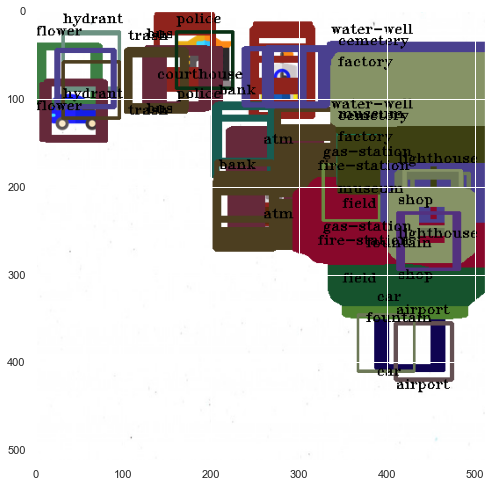

KeyboardInterrupt: Interrupted by user

In [355]:
for image in image_results:
    plt.figure()
    plt.imshow(image)
    plt.show()
    results.append(input())

## Testing Accuracy vs Threshold

In [171]:
target = cv2.imread("/Users/louisgodtfredsen/Desktop/Work/BATH/Year_3/ComputerVision/Task2Dataset/TestWithoutRotations/images/test_image_1.png")


In [150]:
#Make Template Classes
directory_template = "Task2Dataset/Training/png"
class_list = []
template_dict = dict()
key = "house"
for filename in os.listdir(directory_template):
    f = os.path.join(directory_template, filename)
    # checking if it is a file
    class_name = f.partition("-")[2].partition(".")[0]
    template_pyr = gaussian_pyramid(cv2.imread(f, cv2.IMREAD_GRAYSCALE))
    template_dict[class_name] = template_pyr
    
template_options = template_dict[key]
target, text_coord = single_template_match(target, template_options, key)

In [185]:
def calc_iou(boxA_coord, boxB_coord, w, h):
    
    boxA = [boxA_coord[0],boxA_coord[1], boxA_coord[0]+w, boxA_coord[1]+h]
    boxB = [boxB_coord[0],boxB_coord[1], boxB_coord[0]+w, boxB_coord[1]+h]
    
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    
    
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    return iou

In [301]:
#Find coordinates for a single template and returns image with bounding box
def single_temp_match_acc(target, template_options, threshold):
    target_gray = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)
    colour = random_colour()
    text_coord = []
    template_option = template_options[2]
    h, w = template_option.shape
    
    
    #Template Match
    res = cv2.matchTemplate(target_gray, template_option, cv2.TM_CCOEFF_NORMED)
    #Only return points where the probability of a template occuring is above 95%
    loc_true = np.where(res >= 0.95)
    loc_test = np.where(res >= threshold)
    iou_list = []
    
    
    tr_pt = list(zip(*loc_true[::-1]))
    pr_pt = list(zip(*loc_test[::-1]))
    
   
    #Bound found template in image
    
    if len(tr_pt) == 0 and len(pr_pt) > 0:
        acc = 0
    elif len(tr_pt) == 0 and len(pr_pt) == 0:
        acc = 1
    else:
        for pt in pr_pt:
            iou_list.append(calc_iou(tr_pt[0], pt,w,h))
            text_coord.append(pt)
            cv2.rectangle(target, pt, (pt[0] + w, pt[1] + h), colour, 2) 
        acc = np.mean(iou_list)
    return target, acc


In [297]:
#Make Template Classes
target = cv2.imread("/Users/louisgodtfredsen/Desktop/Work/BATH/Year_3/ComputerVision/Task2Dataset/TestWithoutRotations/images/test_image_1.png")

directory_template = "Task2Dataset/Training/png"
class_list = []
template_dict = dict()
keys = template_dict.keys()

for filename in os.listdir(directory_template):
    f = os.path.join(directory_template, filename)
    # checking if it is a file
    class_name = f.partition("-")[2].partition(".")[0]
    template_pyr = gaussian_pyramid(cv2.imread(f, cv2.IMREAD_GRAYSCALE))
    template_dict[class_name] = template_pyr

directory_test = "Task2Dataset/TestWithoutRotations/images"
test_images_numbers = []

for filename in os.listdir(directory_test):
    f = os.path.join(directory_test, filename)
    image_number = f.partition("_")[2].partition("_")[2].partition(".")[0]
    test_images_numbers.append(image_number)
    

    
def calc_acc_for_thresh(threshold):
    final_template_results = []
    for key in keys:
        template_options = template_dict[key]
        template_row_results = []
        for filename in os.listdir(directory_test):
            f = os.path.join(directory_test, filename)
            target = cv2.imread(f)
            target, acc = single_temp_match_acc(target, template_options, threshold)
            template_row_results.append(acc)
        final_template_results.append(template_row_results)
        
    return final_template_results
    


In [336]:
df = pd.DataFrame()
for x in range(9):
    acc_results = calc_acc_for_thresh(0.5+x*0.05)
    final_template_average_results = [np.mean(x) for x in acc_results]
    df[str(round(0.5+x*0.05,2))] = final_template_average_results
    

df.index = keys


In [337]:
template_options = template_dict["sign"]
template_row_results = []
for filename in os.listdir(directory_test):
            f = os.path.join(directory_test, filename)
            target = cv2.imread(f)
            target, acc = single_temp_match_acc(target, template_options, 0.5)
            template_row_results.append(acc)

In [338]:
df = df.T
df_average = pd.DataFrame()
df_average.index = [round(0.5+x*0.05,2) for x in range(9)]
resultant_threshold_averages = df.mean(axis=1).values.tolist()
df_average["Overall Average Accuracy for all Templates"] = resultant_threshold_averages

In [339]:
df_average

,Overall Average_Accuracy For Templates
0.50,0.441881
0.55,0.621224
0.60,0.772274
0.65,0.867439
0.70,0.943980
0.75,0.968506
0.80,0.985890
0.85,0.995054
0.90,0.996154


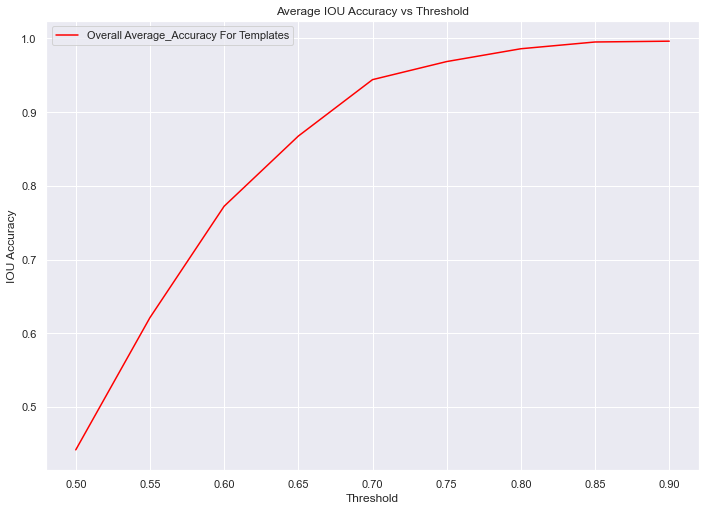

In [353]:
ax = sns.lineplot(data=df_average,palette=("red",))
ax.set(xlabel='Threshold', ylabel='IOU Accuracy', title="Average IOU Accuracy vs Threshold")
plt.show()

In [354]:
df

,bridge,theater,sign,solar-panel,courthouse,library,atm,cinema,flower,prison,...,gas-station,factory,bench,water-well,bus-stop,post-office,lighthouse,cemetery,shop,school
0.5,0.804667,0.978557,0.85,0.7,0.045381,0.043360,0.565005,0.994607,0.141080,0.079006,...,0.398435,0.426676,1.0,0.034677,0.942202,0.983585,0.05,0.052773,0.941961,0.072270
0.55,0.913625,0.981364,1.00,0.9,0.110426,0.243946,0.740655,0.994984,0.318249,0.240778,...,0.777723,0.739177,1.0,0.157269,0.993204,0.985395,0.20,0.087653,0.993235,0.742474
0.6,0.982655,0.983772,1.00,1.0,0.636522,0.994593,0.752382,0.995532,0.628518,0.643212,...,0.984946,0.895413,1.0,0.570212,0.994032,0.986458,0.50,0.168934,0.994215,0.893593
0.65,0.985071,0.986172,1.00,1.0,0.638477,0.995160,0.765346,0.995941,0.838344,0.994355,...,0.987085,0.995893,1.0,0.839918,0.994967,0.987885,0.80,0.703218,0.995188,0.894685
0.7,0.986080,0.988382,1.00,1.0,0.790416,0.995590,0.928484,0.996544,0.989796,0.995338,...,0.988760,0.996347,1.0,0.991625,0.995488,0.989442,1.00,0.823182,0.995815,0.995591
0.75,0.988590,0.989786,1.00,1.0,0.991714,0.996163,0.933095,0.996731,0.991486,0.996007,...,0.990929,0.996715,1.0,0.992273,0.996319,0.991158,1.00,0.977207,0.996601,0.996253
0.8,0.991088,0.991686,1.00,1.0,0.993543,0.996973,0.986496,0.997529,0.992547,0.996606,...,0.991686,0.997335,1.0,0.993543,0.996748,0.992037,1.00,0.981719,0.996969,0.996772
0.85,0.991088,0.993103,1.00,1.0,0.994713,0.997451,0.988067,0.997770,0.993946,0.997529,...,0.993553,0.997575,1.0,0.995057,0.997478,0.993316,1.00,0.985470,0.997484,0.997529
0.9,0.994007,0.995495,1.00,1.0,0.995544,0.997772,0.989493,0.998502,0.995544,0.998010,...,0.994764,0.998498,1.0,0.995340,0.998251,0.995505,1.00,0.988972,0.998251,0.997928
